In [ ]:
#This is a notebook adaption of the DevNet algorithm of Pang et al
# -*- coding: utf-8 -*-
"""
@author: Guansong Pang
The algorithm was implemented using Python 3.6.6, Keras 2.2.2 and TensorFlow 1.10.1.
More details can be found in our KDD19 paper.
Guansong Pang, Chunhua Shen, and Anton van den Hengel. 2019. 
Deep Anomaly Detection with Deviation Networks. 
In The 25th ACM SIGKDDConference on Knowledge Discovery and Data Mining (KDD ’19),
August4–8, 2019, Anchorage, AK, USA.ACM, New York, NY, USA, 10 pages. https://doi.org/10.1145/3292500.3330871
"""
#it has been modified minimally to work with colab using the goole tensorflow1.x platform 
#as of December 2021 this required the notebook run with an earlier version of h5py

'\n@author: Guansong Pang\nThe algorithm was implemented using Python 3.6.6, Keras 2.2.2 and TensorFlow 1.10.1.\nMore details can be found in our KDD19 paper.\nGuansong Pang, Chunhua Shen, and Anton van den Hengel. 2019. \nDeep Anomaly Detection with Deviation Networks. \nIn The 25th ACM SIGKDDConference on Knowledge Discovery and Data Mining (KDD ’19),\nAugust4–8, 2019, Anchorage, AK, USA.ACM, New York, NY, USA, 10 pages. https://doi.org/10.1145/3292500.3330871\n'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# make one local directories named model
import os
os.mkdir('./model')


In [ ]:
%tensorflow_version 1.x
!pip uninstall h5py
!pip install 'h5py<3.0.0'

TensorFlow 1.x selected.


In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics import auc,roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.datasets import load_svmlight_file


def dataLoading(path):
    # loading data
    df = pd.read_csv(path) 
    
    labels = df['class']
    
    x_df = df.drop(['class'], axis=1)
    
    x = x_df.values
    print("Data shape: (%d, %d)" % x.shape)
    
    return x, labels;


def aucPerformance(mse, labels):
    roc_auc = roc_auc_score(labels, mse)
    ap = average_precision_score(labels, mse)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    return roc_auc, ap;

def writeResults(name, n_samples, dim, n_samples_trn, n_outliers_trn, n_outliers, depth, rauc, ap, std_auc, std_ap, train_time, test_time, path = "./results/auc_performance_cl0.5.csv"):    
    csv_file = open(path, 'a') 
    row = name + "," + str(n_samples)+ ","  + str(dim) + ',' + str(n_samples_trn) + ','+ str(n_outliers_trn) + ','+ str(n_outliers)  + ',' + str(depth)+ "," + str(rauc) +"," + str(std_auc) + "," + str(ap) +"," + str(std_ap)+"," + str(train_time)+"," + str(test_time) + "\n"
    csv_file.write(row)




In [ ]:
import numpy as np

import tensorflow as tf
from keras import regularizers
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.sparse import vstack, csc_matrix
#from utils import dataLoading, aucPerformance, writeResults   #notebook version
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, plot_precision_recall_curve

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

import time

Using TensorFlow backend.


In [ ]:
def dev_network_d(input_shape):
    '''
    deeper network architecture with three hidden layers
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1000, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(250, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl2')(intermediate)
    intermediate = Dense(20, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl3')(intermediate)
    intermediate = Dense(1, activation='linear', name = 'score')(intermediate)
    return Model(x_input, intermediate)

def dev_network_s(input_shape):
    '''
    network architecture with one hidden layer
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(20, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(1, activation='linear',  name = 'score')(intermediate)    
    return Model(x_input, intermediate)

def dev_network_linear(input_shape):
    '''
    network architecture with no hidden layer, equivalent to linear mapping from
    raw inputs to anomaly scores
    '''    
    x_input = Input(shape=input_shape)
    intermediate = Dense(1, activation='linear',  name = 'score')(x_input)
    return Model(x_input, intermediate)

def deviation_loss(y_true, y_pred):
    '''
    z-score-based deviation loss
    '''    
    confidence_margin = 5.     
    ## size=5000 is the setting of l in algorithm 1 in the paper
    ref = K.variable(np.random.normal(loc = 0., scale= 1.0, size = 5000) , dtype='float32')
    dev = (y_pred - K.mean(ref)) / K.std(ref)
    inlier_loss = K.abs(dev) 
    outlier_loss = K.abs(K.maximum(confidence_margin - dev, 0.))
    return K.mean((1 - y_true) * inlier_loss + y_true * outlier_loss)


def deviation_network(input_shape, network_depth):
    '''
    construct the deviation network-based detection model
    '''
    if network_depth == 4:
        model = dev_network_d(input_shape)
    elif network_depth == 2:
        model = dev_network_s(input_shape)
    elif network_depth == 1:
        model = dev_network_linear(input_shape)
    else:
        sys.exit("The network depth is not set properly")
    rms = RMSprop(clipnorm=1.)
    model.compile(loss=deviation_loss, optimizer=rms)
    return model


def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
    counter = 0
    while 1:                
        if data_format == 0:
            ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
        else:
            ref, training_labels = input_batch_generation_sup_sparse(x, outlier_indices, inlier_indices, batch_size, rng)
        counter += 1
        yield(ref, training_labels)
        if (counter > nb_batch):
            counter = 0
 
def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for csv data.
    Alternates between positive and negative pairs.
    '''      
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))    
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):    
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = x_train[outlier_indices[sid]]
            training_labels += [1]
    return np.array(ref), np.array(training_labels)

 
def input_batch_generation_sup_sparse(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for libsvm stored sparse data.
    Alternates between positive and negative pairs.
    '''      
    ref = np.empty((batch_size))    
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):    
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = inlier_indices[sid]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = outlier_indices[sid]
            training_labels += [1]
    ref = x_train[ref, :].toarray()
    return ref, np.array(training_labels)


def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
    '''
    load the saved weights to make predictions
    '''
    model = deviation_network(input_shape, network_depth)
    model.load_weights(model_name)
    scoring_network = Model(inputs=model.input, outputs=model.output)    
    
    if data_format == 0:
        scores = scoring_network.predict(x_test)
    else:
        data_size = x_test.shape[0]
        scores = np.zeros([data_size, 1])
        count = 512
        i = 0
        while i < data_size:
            subset = x_test[i:count].toarray()
            scores[i:count] = scoring_network.predict(subset)
            if i % 1024 == 0:
                print(i)
            i = count
            count += 512
            if count > data_size:
                count = data_size
        assert count == data_size
    return scores


def inject_noise_sparse(seed, n_out, random_seed):  
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    This is for sparse data.
    '''
    rng = np.random.RandomState(random_seed) 
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    seed = seed.tocsc()
    noise = csc_matrix((n_out, dim))
    print(noise.shape)
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[0, swap_feats]
    return noise.tocsr()

def inject_noise(seed, n_out, random_seed):   
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    this is for dense data
    '''  
    rng = np.random.RandomState(random_seed) 
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    noise = np.empty((n_out, dim))
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[swap_feats]
    return noise

def plotAUCPRCurve(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(recall, precision)
    fig.suptitle('DevNet AUC-PR ', fontsize=20)
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=16)
    plt.show()

    # Data to plot precision - recall curve
    # PrecisionRecallDisplay.from_predictions(y_test, y_score)
    # RocCurveDisplay.from_predictions( y_test, y_score)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    fig = plt.figure()
    plt.plot(fpr, tpr)
    fig.suptitle('DevNet AUC-ROC ', fontsize=20)
    plt.xlabel('FPR', fontsize=18)
    plt.ylabel('TPR', fontsize=16)
    plt.show()



In [ ]:
def run_devnet(data_set, 
               n_depth, 
               ramdn_seed, 
               runs, 
               data_format, 
               input_path,cont_rate, 
               known_outliers,
               epochs,
               batch_size,
               nb_batch,
               output):

    names = data_set.split(',')
    #names = ['annthyroid_21feat_normalised']
    network_depth = int(n_depth)
    random_seed = ramdn_seed
    for nm in names:
        runs = runs
        rauc = np.zeros(runs)
        ap = np.zeros(runs)  
        filename = nm.strip()
        #global data_format   # what does global do?
        data_format = int(data_format)
        if data_format == 0:
            x, labels = dataLoading(input_path + filename + ".csv")
        else:
            pass
            #x, labels = get_data_from_svmlight_file(input_path + filename + ".svm")
            #x = x.tocsr()
        outlier_indices = np.where(labels == 1)[0]
        outliers = x[outlier_indices]  
        n_outliers_org = outliers.shape[0]   
        
        train_time = 0
        test_time = 0
        for i in np.arange(runs):  
            x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42, stratify = labels)
            y_train = np.array(y_train)
            y_test = np.array(y_test)
            print(filename + ': round ' + str(i))
            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            n_outliers = len(outlier_indices)
            print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))
            
            n_noise  = len(np.where(y_train == 0)[0]) * cont_rate / (1. - cont_rate)
            n_noise = int(n_noise)                
            
            rng = np.random.RandomState(random_seed)  
            if data_format == 0:                
                if n_outliers > known_outliers:
                    mn = n_outliers - known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)            
                    x_train = np.delete(x_train, remove_idx, axis=0)
                    y_train = np.delete(y_train, remove_idx, axis=0)
                
                noises = inject_noise(outliers, n_noise, random_seed)
                x_train = np.append(x_train, noises, axis = 0)
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))
            
            else:
                if n_outliers > known_outliers:
                    mn = n_outliers - known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)        
                    retain_idx = set(np.arange(x_train.shape[0])) - set(remove_idx)
                    retain_idx = list(retain_idx)
                    x_train = x_train[retain_idx]
                    y_train = y_train[retain_idx]                               
                
                noises = inject_noise_sparse(outliers, n_noise, random_seed)
                x_train = vstack([x_train, noises])
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))
            
            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            print(y_train.shape[0], outlier_indices.shape[0], inlier_indices.shape[0], n_noise)
            input_shape = x_train.shape[1:]
            n_samples_trn = x_train.shape[0]
            n_outliers = len(outlier_indices)            
            print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))
            
            
            start_time = time.time() 
            input_shape = x_train.shape[1:]
            epochs = epochs
            batch_size = batch_size    
            nb_batch = nb_batch  
            model = deviation_network(input_shape, network_depth)
            print(model.summary())  
            model_name = "./model/devnet_"  + filename + "_" + str(cont_rate) + "cr_"  + str(batch_size) +"bs_" + str(known_outliers) + "ko_" + str(network_depth) +"d.h5"
            checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0,
                                           save_best_only = True, save_weights_only = True)            
            
            model.fit_generator(batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
                                          steps_per_epoch = nb_batch,
                                          epochs = epochs,
                                          callbacks=[checkpointer])   
            train_time += time.time() - start_time
            
            start_time = time.time() 
            scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
            test_time += time.time() - start_time
            rauc[i], ap[i] = aucPerformance(scores, y_test)
            plotAUCPRCurve(y_test, scores)
        mean_auc = np.mean(rauc)
        std_auc = np.std(rauc)
        mean_aucpr = np.mean(ap)
        std_aucpr = np.std(ap)
        train_time = train_time/runs
        test_time = test_time/runs
        print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))    
        print("average runtime: %.4f seconds" % (train_time + test_time))
        writeResults(filename+'_'+str(network_depth), x.shape[0], x.shape[1], n_samples_trn, n_outliers_org, n_outliers,
        network_depth, mean_auc, mean_aucpr, std_auc, std_aucpr, train_time, test_time, path=output)



Data shape: (284807, 29)
cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 0
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_161 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 139ms/step - loss: 2.6155
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 2.3655
Epoch 3/50
20/20 [=========

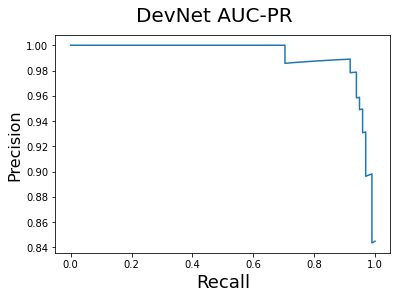

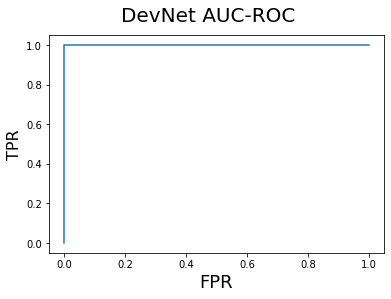

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 1
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_244"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_163 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 140ms/step - loss: 2.4963
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 2.2134
Epoch 3/50
20/20 [==============================] - 

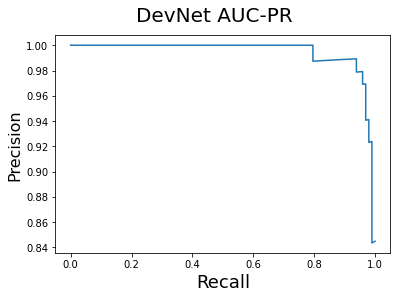

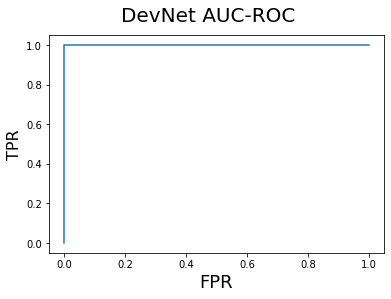

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 2
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 142ms/step - loss: 2.5321
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 2.2708
Epoch 3/50
20/20 [==============================] - 

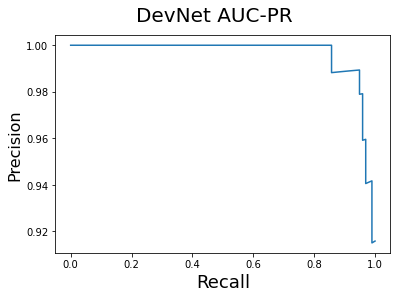

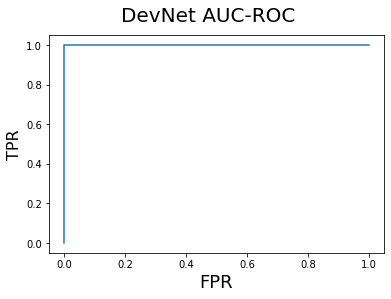

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 3
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_167 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 140ms/step - loss: 2.8917
Epoch 2/50
20/20 [==============================] - 0s 15ms/step - loss: 2.5110
Epoch 3/50
20/20 [==============================] - 

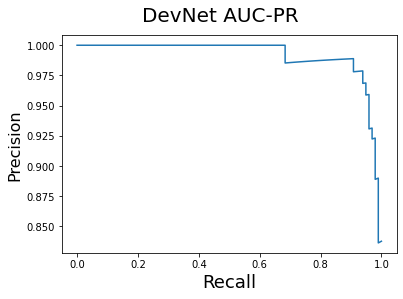

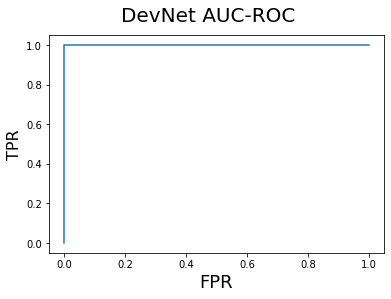

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 4
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_253"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_169 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 146ms/step - loss: 2.5437
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 2.3141
Epoch 3/50
20/20 [==============================] - 

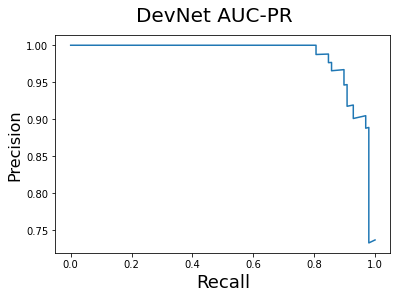

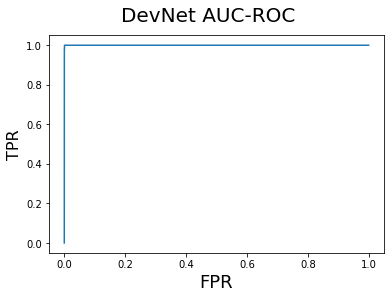

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 5
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_171 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 146ms/step - loss: 2.6771
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 2.5298
Epoch 3/50
20/20 [==============================] - 

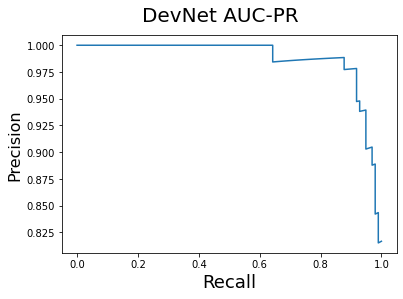

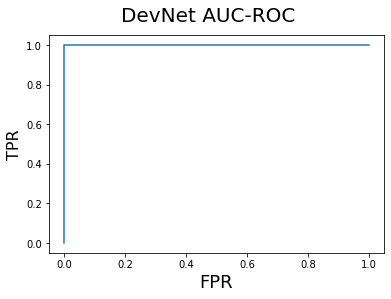

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 6
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_173 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 147ms/step - loss: 2.6599
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 2.3935
Epoch 3/50
20/20 [==============================] - 

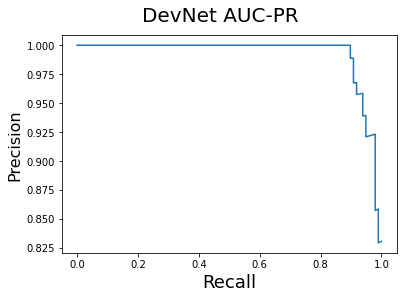

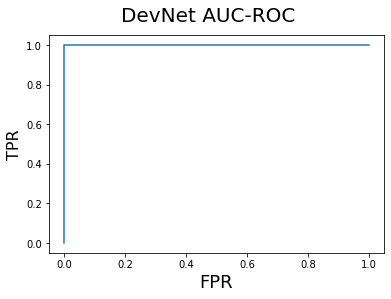

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 7
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_175 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 150ms/step - loss: 2.5225
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.2676
Epoch 3/50
20/20 [==============================] - 

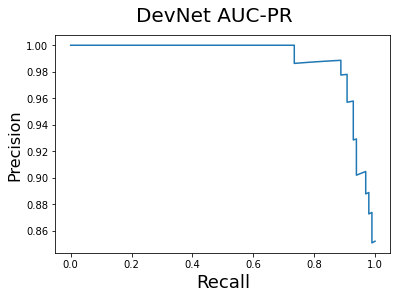

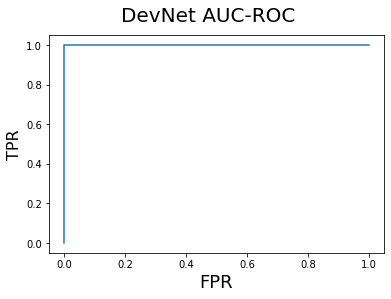

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 8
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_265"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_177 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 155ms/step - loss: 2.6057
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 2.3633
Epoch 3/50
20/20 [==============================] - 

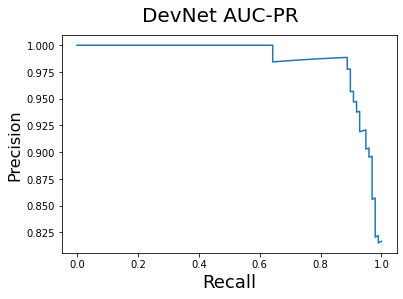

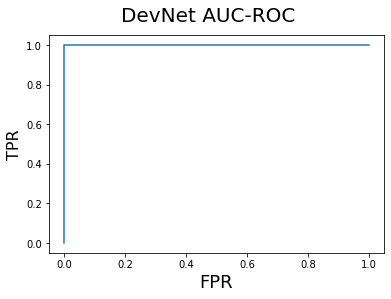

cc_synthetic_cauchy_mn_scale_0.5_cov_scale_0.5: round 9
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_268"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_179 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 152ms/step - loss: 2.4775
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 2.2995
Epoch 3/50
20/20 [==============================] - 

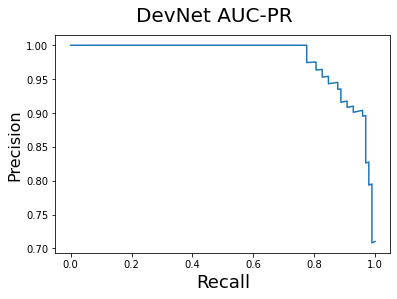

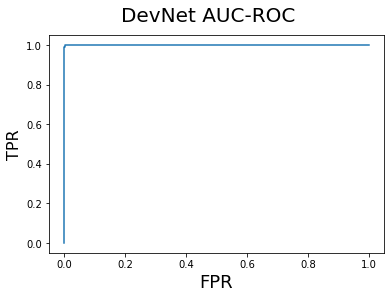

average AUC-ROC: 1.0000, average AUC-PR: 0.9896
average runtime: 53.5043 seconds
Data shape: (284807, 29)
cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 0
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_181 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 152ms/step - loss: 2.7143
Epoch 2/50
20/20 [==========

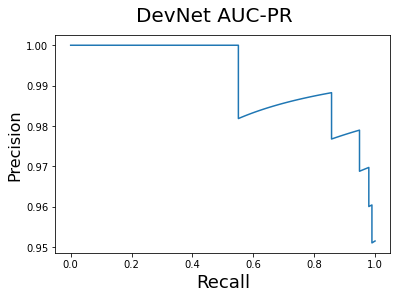

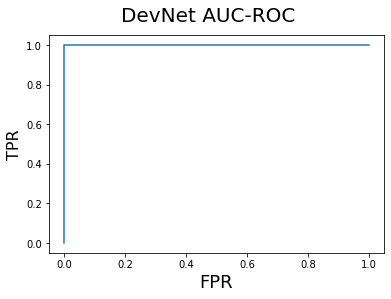

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 1
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_274"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_183 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 157ms/step - loss: 2.4851
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.2737
Epoch 3/50
20/20 [==============================] - 1s

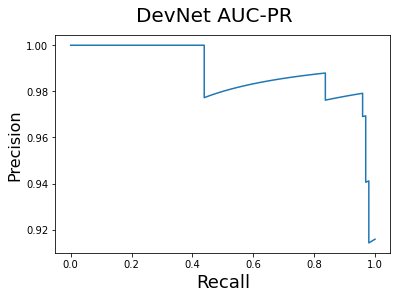

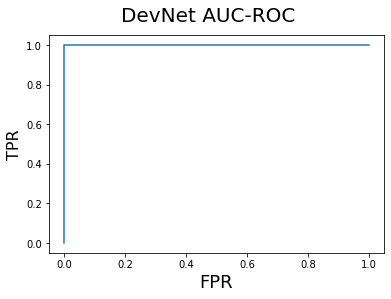

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 2
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_277"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_185 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 161ms/step - loss: 2.3868
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.0962
Epoch 3/50
20/20 [==============================] - 1s

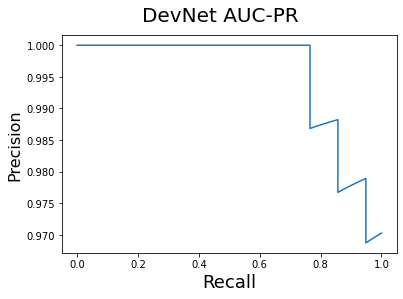

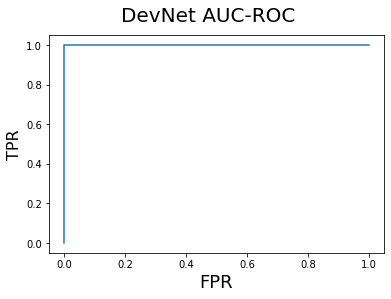

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 3
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_187 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 157ms/step - loss: 2.9226
Epoch 2/50
20/20 [==============================] - 0s 20ms/step - loss: 2.5843
Epoch 3/50
20/20 [==============================] - 1s

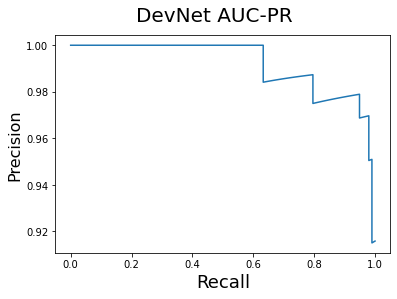

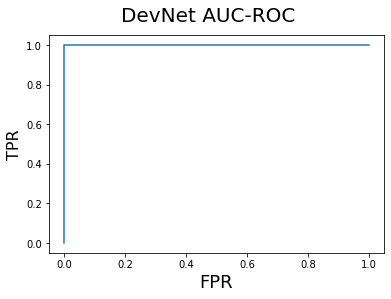

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 4
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_283"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_189 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 160ms/step - loss: 2.5069
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 2.1136
Epoch 3/50
20/20 [==============================] - 1s

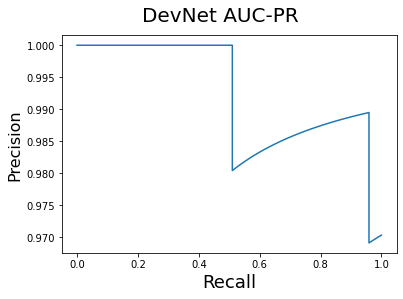

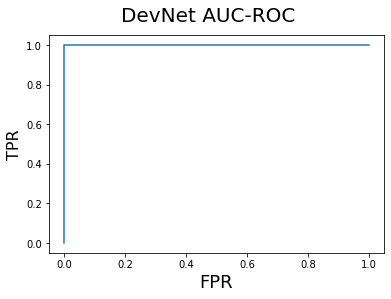

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 5
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_286"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_191 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 161ms/step - loss: 2.3733
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.1423
Epoch 3/50
20/20 [==============================] - 1s

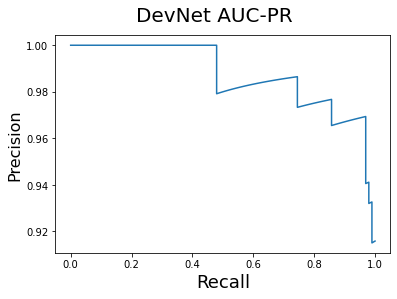

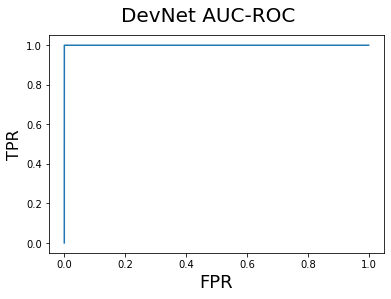

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 6
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_289"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_193 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 162ms/step - loss: 2.5519
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.3273
Epoch 3/50
20/20 [==============================] - 1s

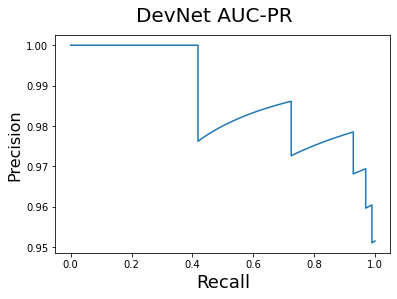

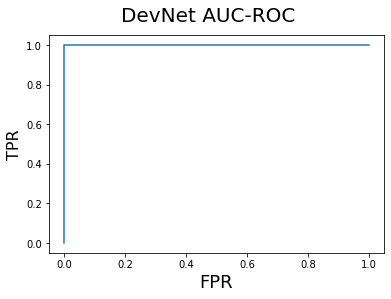

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 7
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_195 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 166ms/step - loss: 2.4872
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.2780
Epoch 3/50
20/20 [==============================] - 1s

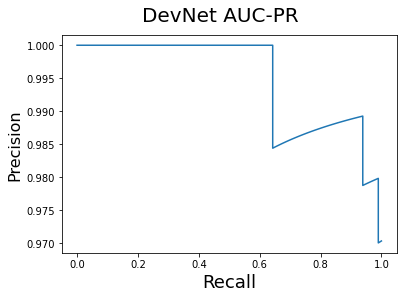

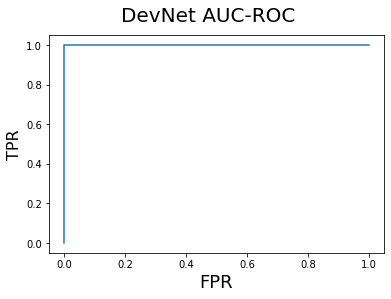

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 8
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_295"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_197 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 166ms/step - loss: 2.7147
Epoch 2/50
20/20 [==============================] - 0s 19ms/step - loss: 2.4195
Epoch 3/50
20/20 [==============================] - 1s

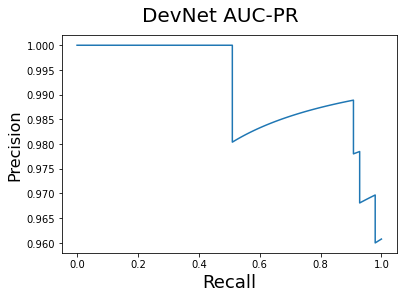

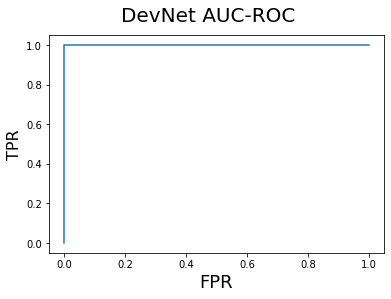

cc_synthetic_cauchy_mn_scale_1_cov_scale_0.5: round 9
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_298"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_199 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 173ms/step - loss: 2.5212
Epoch 2/50
20/20 [==============================] - 0s 18ms/step - loss: 2.3328
Epoch 3/50
20/20 [==============================] - 1s

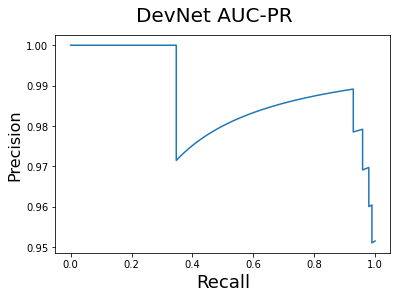

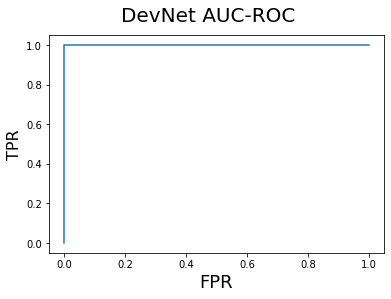

average AUC-ROC: 1.0000, average AUC-PR: 0.9908
average runtime: 58.0209 seconds
Data shape: (284807, 29)
cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 0
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_201 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 3s 170ms/step - loss: 2.4062
Epoch 2/50
20/20 [========

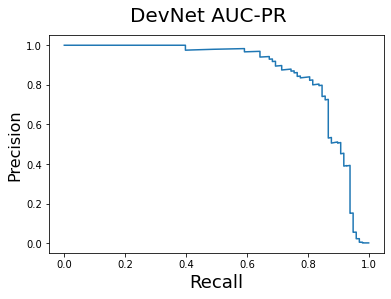

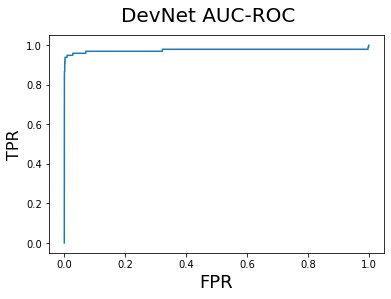

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 1
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_304"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_203 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 184ms/step - loss: 2.7053
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 2.5427
Epoch 3/50
20/20 [==============================] - 

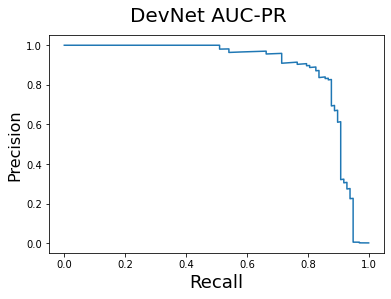

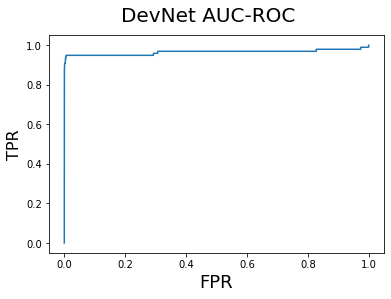

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 2
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_307"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_205 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 193ms/step - loss: 2.7368
Epoch 2/50
20/20 [==============================] - 0s 24ms/step - loss: 2.5749
Epoch 3/50
20/20 [==============================] - 

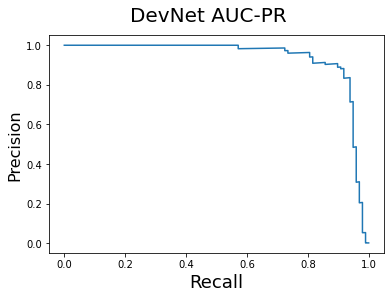

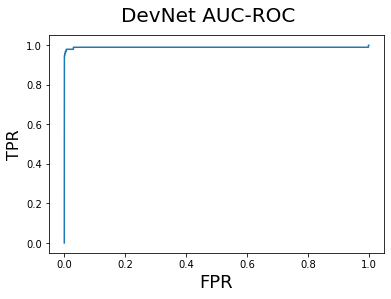

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 3
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_310"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_207 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 199ms/step - loss: 2.6983
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 2.4851
Epoch 3/50
20/20 [==============================] - 

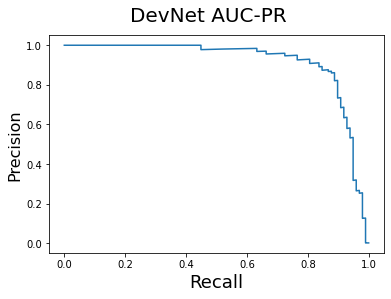

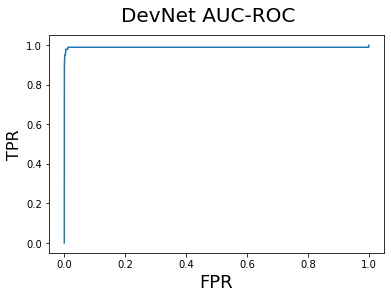

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 4
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_313"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_209 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 199ms/step - loss: 2.5842
Epoch 2/50
20/20 [==============================] - 0s 24ms/step - loss: 2.3752
Epoch 3/50
20/20 [==============================] - 

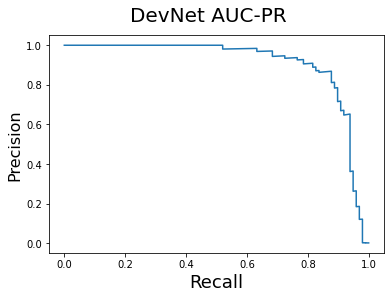

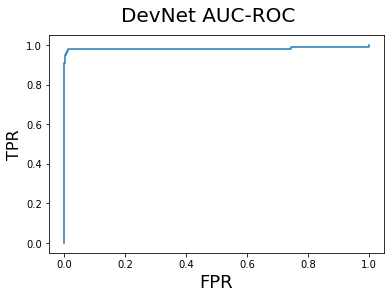

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 5
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_211 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 203ms/step - loss: 2.7657
Epoch 2/50
20/20 [==============================] - 1s 29ms/step - loss: 2.5074
Epoch 3/50
20/20 [==============================] - 

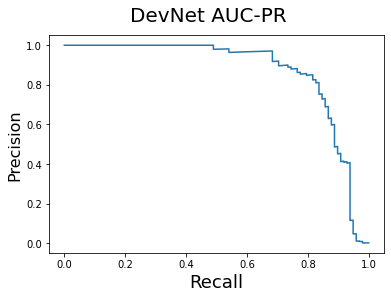

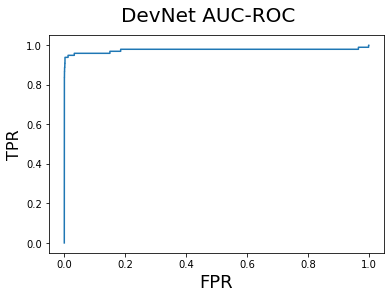

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 6
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_319"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_213 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 210ms/step - loss: 2.6182
Epoch 2/50
20/20 [==============================] - 0s 24ms/step - loss: 2.3349
Epoch 3/50
20/20 [==============================] - 

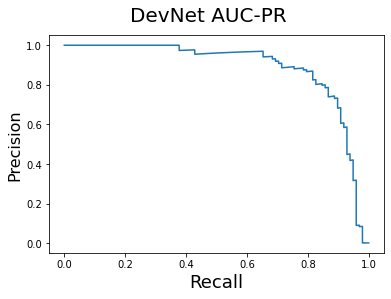

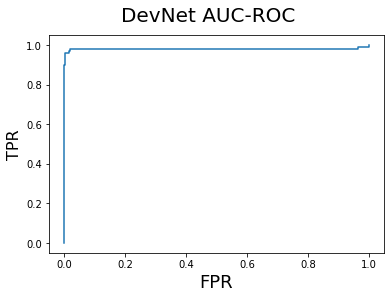

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 7
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_215 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 201ms/step - loss: 2.5413
Epoch 2/50
20/20 [==============================] - 0s 23ms/step - loss: 2.4022
Epoch 3/50
20/20 [==============================] - 

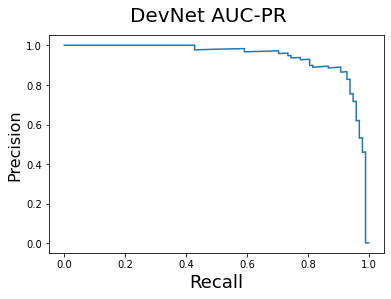

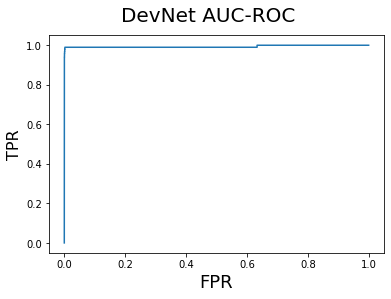

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 8
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_325"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_217 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 222ms/step - loss: 3.5654
Epoch 2/50
20/20 [==============================] - 0s 24ms/step - loss: 2.6596
Epoch 3/50
20/20 [==============================] - 

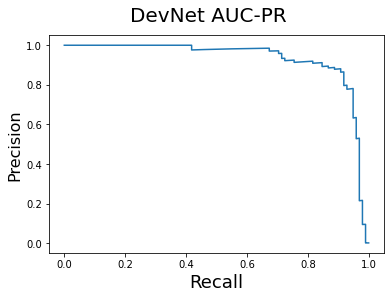

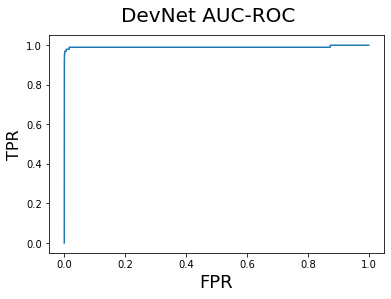

cc_synthetic_cauchy_mn_scale_1.1_cov_scale_0.5: round 9
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_328"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_219 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 188ms/step - loss: 2.5189
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 2.3265
Epoch 3/50
20/20 [==============================] - 

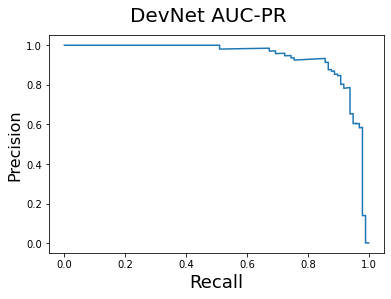

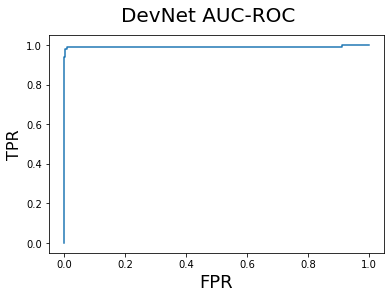

average AUC-ROC: 0.9831, average AUC-PR: 0.9088
average runtime: 70.3790 seconds
Data shape: (284807, 29)
cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 0
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_221 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 190ms/step - loss: 2.5726
Epoch 2/50
20/20 [========

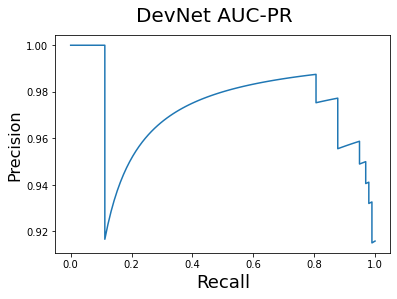

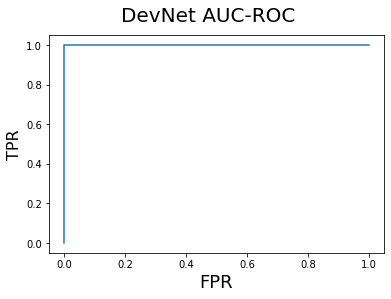

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 1
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_334"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_223 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 186ms/step - loss: 2.6353
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 2.4691
Epoch 3/50
20/20 [==============================] - 

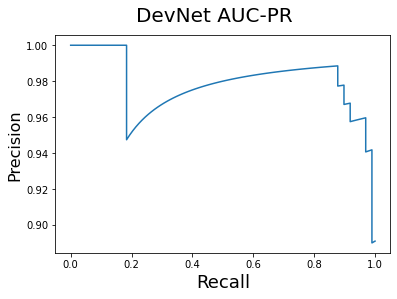

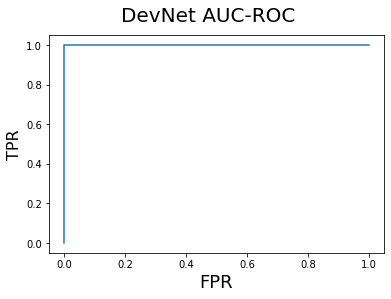

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 2
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_337"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_225 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 196ms/step - loss: 2.5790
Epoch 2/50
20/20 [==============================] - 0s 23ms/step - loss: 2.3665
Epoch 3/50
20/20 [==============================] - 

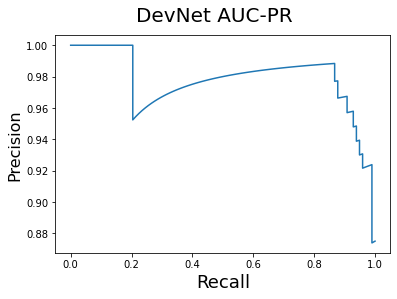

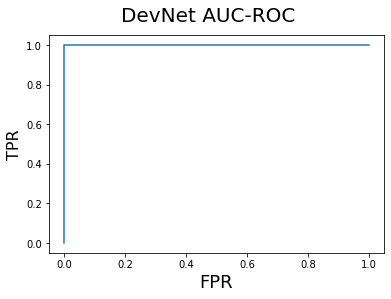

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 3
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_227 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 189ms/step - loss: 2.6500
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 2.4987
Epoch 3/50
20/20 [==============================] - 

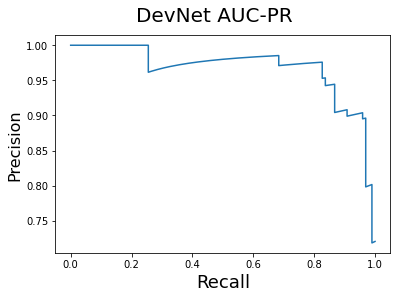

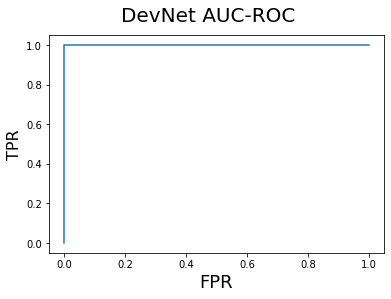

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 4
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_229 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 192ms/step - loss: 2.6424
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 2.3737
Epoch 3/50
20/20 [==============================] - 

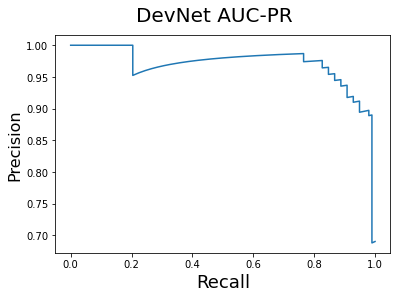

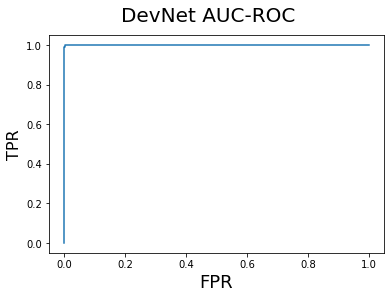

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 5
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_346"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_231 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 195ms/step - loss: 2.6189
Epoch 2/50
20/20 [==============================] - 0s 20ms/step - loss: 2.4271
Epoch 3/50
20/20 [==============================] - 

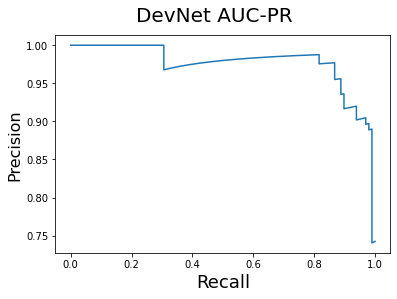

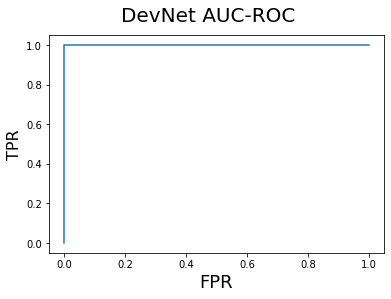

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 6
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_349"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_233 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 190ms/step - loss: 2.5669
Epoch 2/50
20/20 [==============================] - 0s 23ms/step - loss: 2.3783
Epoch 3/50
20/20 [==============================] - 

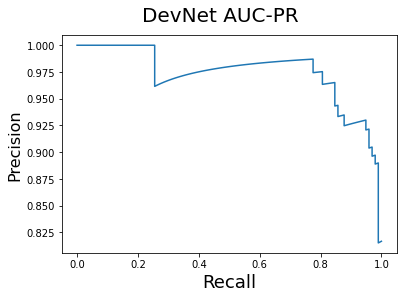

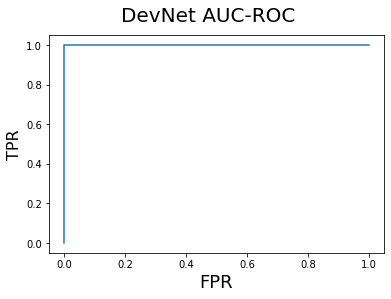

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 7
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_235 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 192ms/step - loss: 2.6173
Epoch 2/50
20/20 [==============================] - 0s 25ms/step - loss: 2.4556
Epoch 3/50
20/20 [==============================] - 

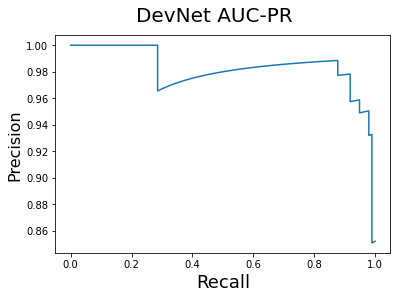

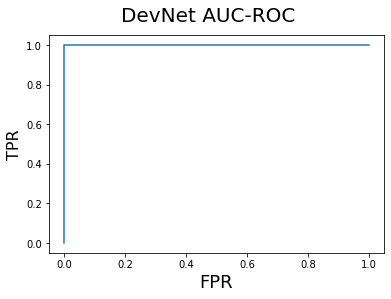

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 8
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_355"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_237 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 197ms/step - loss: 2.3791
Epoch 2/50
20/20 [==============================] - 0s 21ms/step - loss: 2.1700
Epoch 3/50
20/20 [==============================] - 

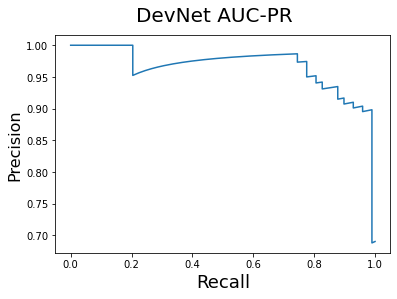

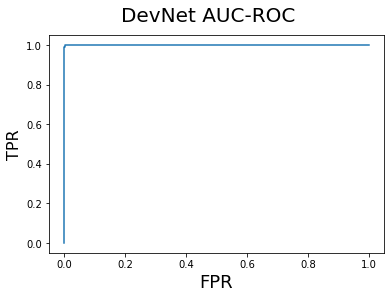

cc_synthetic_cauchy_mn_scale_1.5_cov_scale_0.5: round 9
Original training size: 227845, No. outliers: 394
232093 1 232092 4641
Training data size: 232093, No. outliers: 1
Model: "model_358"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_239 (InputLayer)       (None, 29)                0         
_________________________________________________________________
hl1 (Dense)                  (None, 20)                600       
_________________________________________________________________
score (Dense)                (None, 1)                 21        
Total params: 621
Trainable params: 621
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
20/20 [==============================] - 4s 196ms/step - loss: 2.6249
Epoch 2/50
20/20 [==============================] - 0s 23ms/step - loss: 2.3915
Epoch 3/50
20/20 [==============================] - 

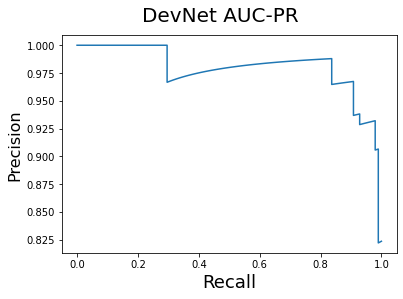

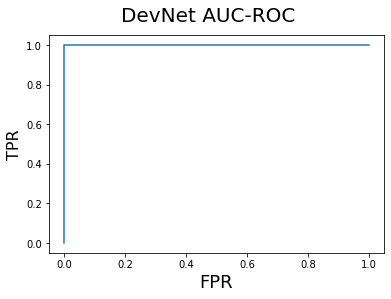

average AUC-ROC: 1.0000, average AUC-PR: 0.9748
average runtime: 66.6278 seconds


In [ ]:
#This is the driver cell
#for each run change the name of the dataset file
#if running semi-supervised intentionally set the number of known outliers (generally 1% may work)
#if running unsupervised then set known_outliers =1
network_depth=2 # choices=['1','2', '4'], default='2', help="the depth of the network architecture")
batch_size=512 # type=int, default=512, help="batch size used in SGD")
nb_batch=20 # type=int, default=20, help="the number of batches per epoch")
epochs=50 #type=int, default=50, help="the number of epochs")
runs=10   #type=int, default=10, help="how many times we repeat the experiments to obtain the average performance")
known_outliers=1 # type=int, default=30, help="the number of labeled outliers available at hand")
cont_rate=0.02 # type=float, default=0.02, help="the outlier contamination rate in the training data")
input_path='gdrive/MyDrive//CSCI5523GroupAnomalyProject/data/'   #type=str, default='./dataset/', help="the path of the data sets")
data_set='annthyroid_21feat_normalised' #type=str, default='annthyroid_21feat_normalised', help="a list of data set names")
data_format=0  # choices=['0','1'], default='0',  help="specify whether the input data is a csv (0) or libsvm (1) data format")
output='gdrive/MyDrive//CSCI5523GroupAnomalyProject/data/results.csv' # type=str, default='./results/devnet_auc_performance_30outliers_0.02contrate_2depth_10runs.csv', help="the output file path")
ramdn_seed=42   # type=int, default=42, help="the random seed number")
network_depth=2 


np.random.seed(42)
tf.set_random_seed(42)
sess = tf.Session()
MAX_INT = np.iinfo(np.int32).max


run_devnet(data_set, 
           network_depth, 
           ramdn_seed, 
           runs, 
           data_format, 
           input_path,cont_rate, 
           known_outliers,
           epochs,
           batch_size,
           nb_batch,
           output)
